# Self-Driving Car Engineer Nanodegree
## Project 3: (Deep Learning) Build a Traffic Sign Recognition Classifier

In this project, I used what I've learned about deep neural networks and convolutional neural networks to classify traffic signs. I trained and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained.

In [1]:
# Load and import dependencies 
import numpy as np
import pickle
from sklearn.utils import shuffle

from utils import summary_data_sets, show_dataset, plot_dataset
from utils import balance_data, rot_pers_transform, rot_pers_transform, add_noisy, norm_and_gray
from utils import get_img_transformations

import matplotlib.pyplot as plt


---
## Step 1: Dataset Loading, Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Dataset Loading

In [2]:
# set where the training and testing data are saved
validation_file = "traffic-signs-data/valid.p"
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

# Read training dataset file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Read validation dataset file
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

# Read testing dataset file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Get features and labels
X_train_raw, y_train_raw = train['features'], train['labels']
X_valid_raw, y_valid_raw = valid['features'], valid['labels']
X_test_raw, y_test_raw = test['features'], test['labels']

# Shuffle all datasets
X_train_raw, y_train_raw = shuffle(X_train_raw, y_train_raw)
X_valid_raw, y_valid_raw = shuffle(X_valid_raw, y_valid_raw)
X_test_raw, y_test_raw = shuffle(X_test_raw, y_test_raw)


### Basic Summary of the Data Set

In [3]:
# Number of training examples
n_train = X_train_raw.shape[0]

# Number of validation examples
n_validation = X_valid_raw.shape[0]

# Number of testing examples.
n_test = X_test_raw.shape[0]

# Total number of samples in dataset
n_total = n_test + n_validation + n_train

# Shape of an traffic sign image
image_shape = X_train_raw.shape[1:]

classes_dics_raw = summary_data_sets(y_train_raw, y_valid_raw, y_test_raw, 'traffic-signs-data/signnames.csv')

# Unique classes/labels in the dataset.
n_classes = len(classes_dics_raw)

# Print dataset report
print("-"*57)
print("| id\t| train\t\t| validation\t| testing\t|")
print("-"*57)
for dic in classes_dics_raw:
    print("| {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t|  {}".format(
        dic["id"], 
        dic["train"]/n_train*100, dic["train"], 
        dic["vali"]/n_validation*100, dic["vali"], 
        dic["test"]/n_test*100, dic["test"], 
        dic["description"][0:30]))
print("-"*57,"\n")    
print("{:.2f}% - Number of training examples \t= {}".format(n_train/n_total*100, n_train))
print("{:.2f}% - Number of validation examples \t= {}".format(n_validation/n_total*100, n_validation))
print("{:.2f}% - Number of testing examples \t= {}".format(n_test/n_total*100, n_test))
print("\nImage data shape =", image_shape)
print("Number of classes =", n_classes)


---------------------------------------------------------
| id	| train		| validation	| testing	|
---------------------------------------------------------
| 0	| 0.52% - 180	| 0.68% - 30	| 0.48% - 60	|  Speed limit (20km/h)
| 1	| 5.69% - 1980	| 5.44% - 240	| 5.70% - 720	|  Speed limit (30km/h)
| 2	| 5.78% - 2010	| 5.44% - 240	| 5.94% - 750	|  Speed limit (50km/h)
| 3	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (60km/h)
| 4	| 5.09% - 1770	| 4.76% - 210	| 5.23% - 660	|  Speed limit (70km/h)
| 5	| 4.74% - 1650	| 4.76% - 210	| 4.99% - 630	|  Speed limit (80km/h)
| 6	| 1.03% - 360	| 1.36% - 60	| 1.19% - 150	|  End of speed limit (80km/h)
| 7	| 3.71% - 1290	| 3.40% - 150	| 3.56% - 450	|  Speed limit (100km/h)
| 8	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (120km/h)
| 9	| 3.79% - 1320	| 3.40% - 150	| 3.80% - 480	|  No passing
| 10	| 5.17% - 1800	| 4.76% - 210	| 5.23% - 660	|  No passing for vehicles over 3
| 11	| 3.36% - 1170	| 3.40% - 150	| 3.33% - 420	|  Right-of

### Exploratory visualization of the dataset

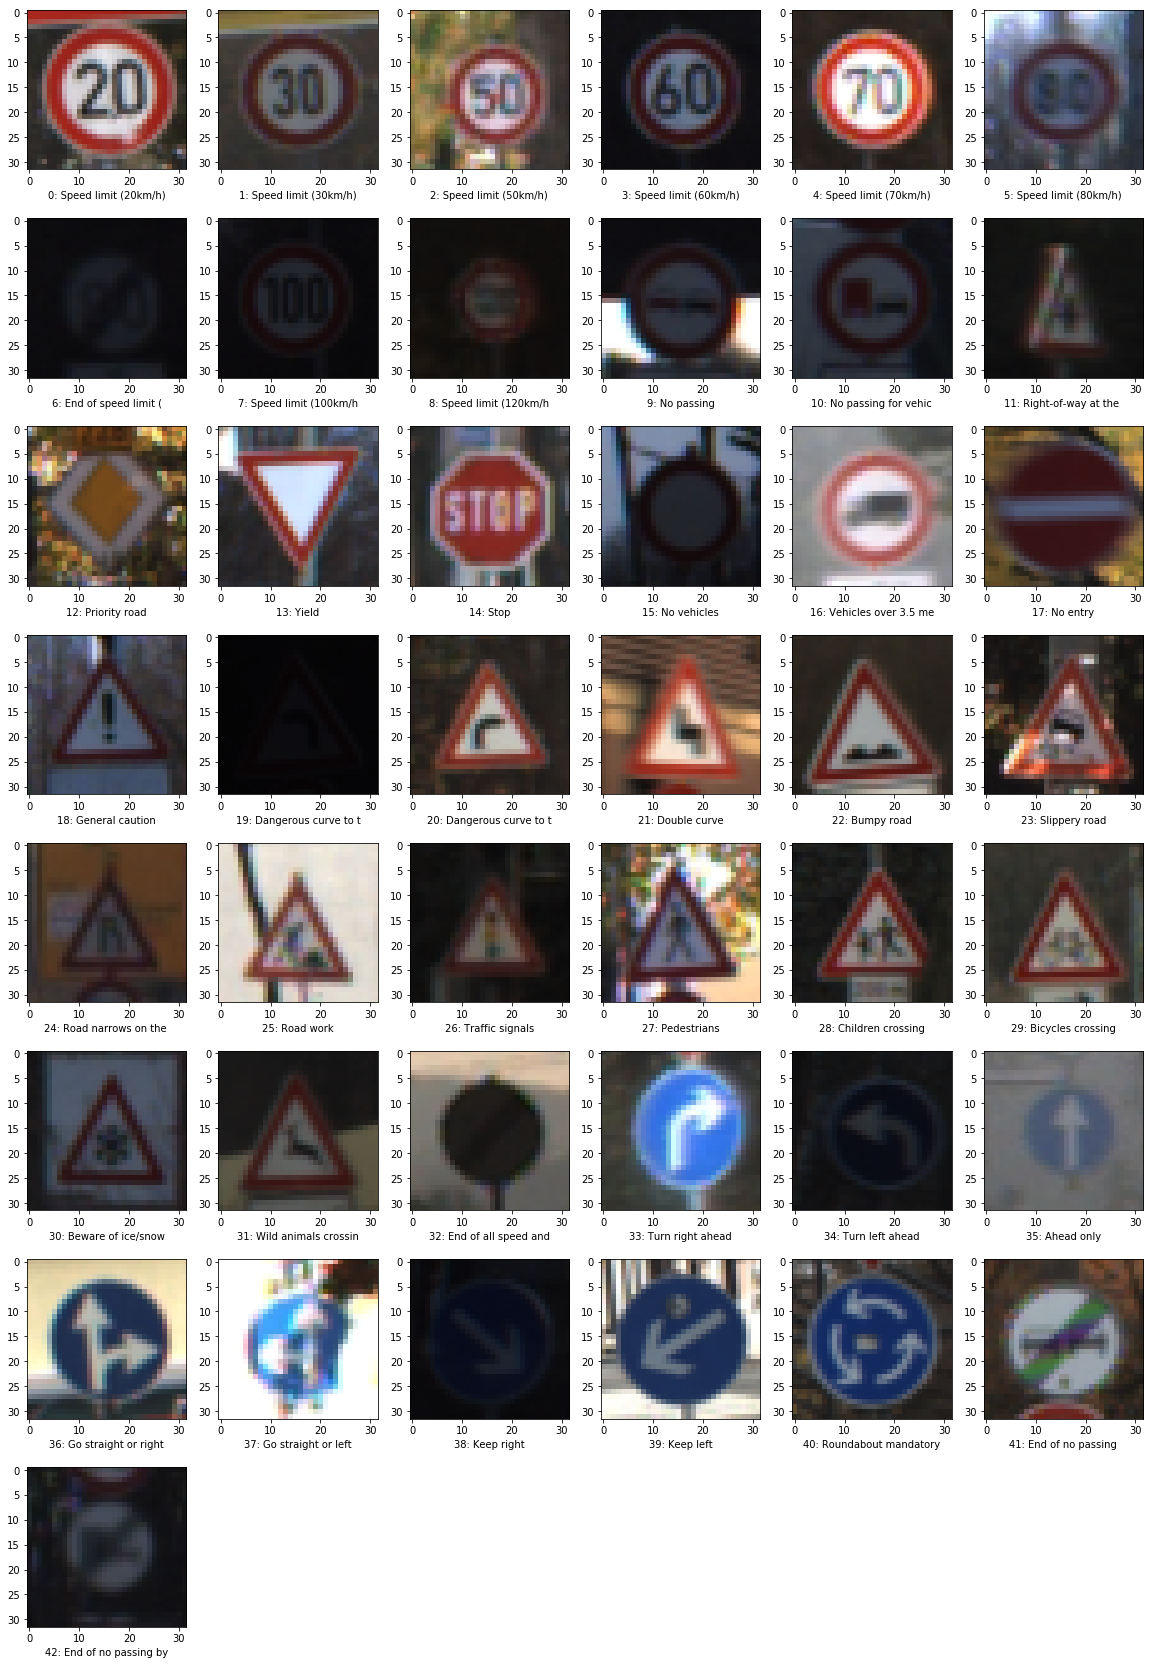

In [4]:
# Show random samples of data set
show_dataset(X_train_raw, classes_dics_raw, data_label = "train", save_name = 'writeup_files/dataset_random_visualization.png')


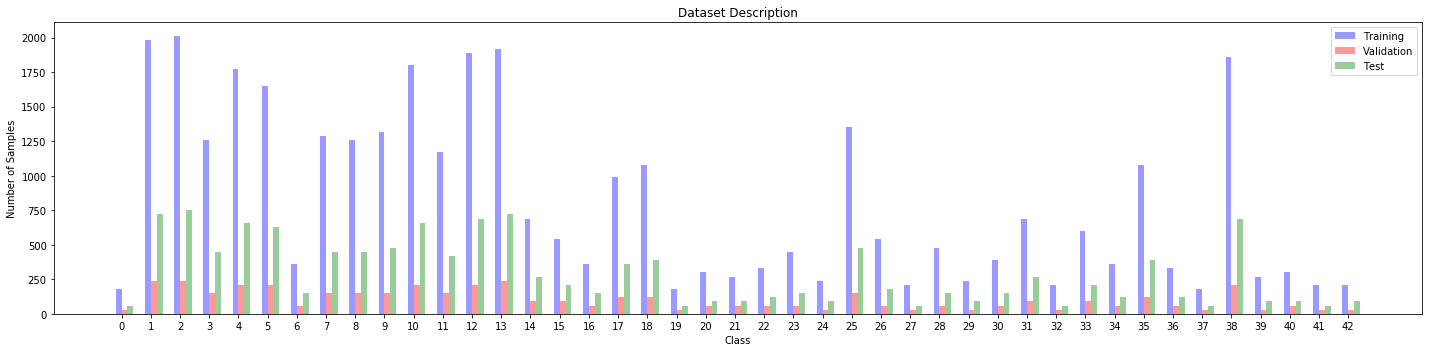

In [5]:
# Get the total of samples for each class for validation, training and test data sets
means_validation = [d['vali'] for d in classes_dics_raw if 'vali' in d]
means_training = [d['train'] for d in classes_dics_raw if 'train' in d]
means_test = [d['test'] for d in classes_dics_raw if 'test' in d]

# Show a random sample for each class
plot_dataset(means_training, means_validation, means_test, n_classes,save_name = 'writeup_files/dataset_description_original_data.png')


### Data Augmentation:  Data Set Pre-processing

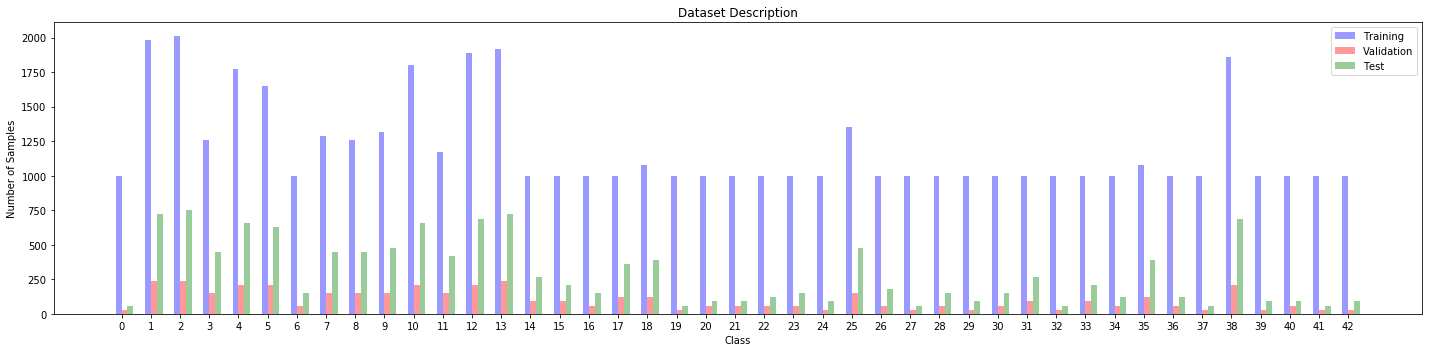

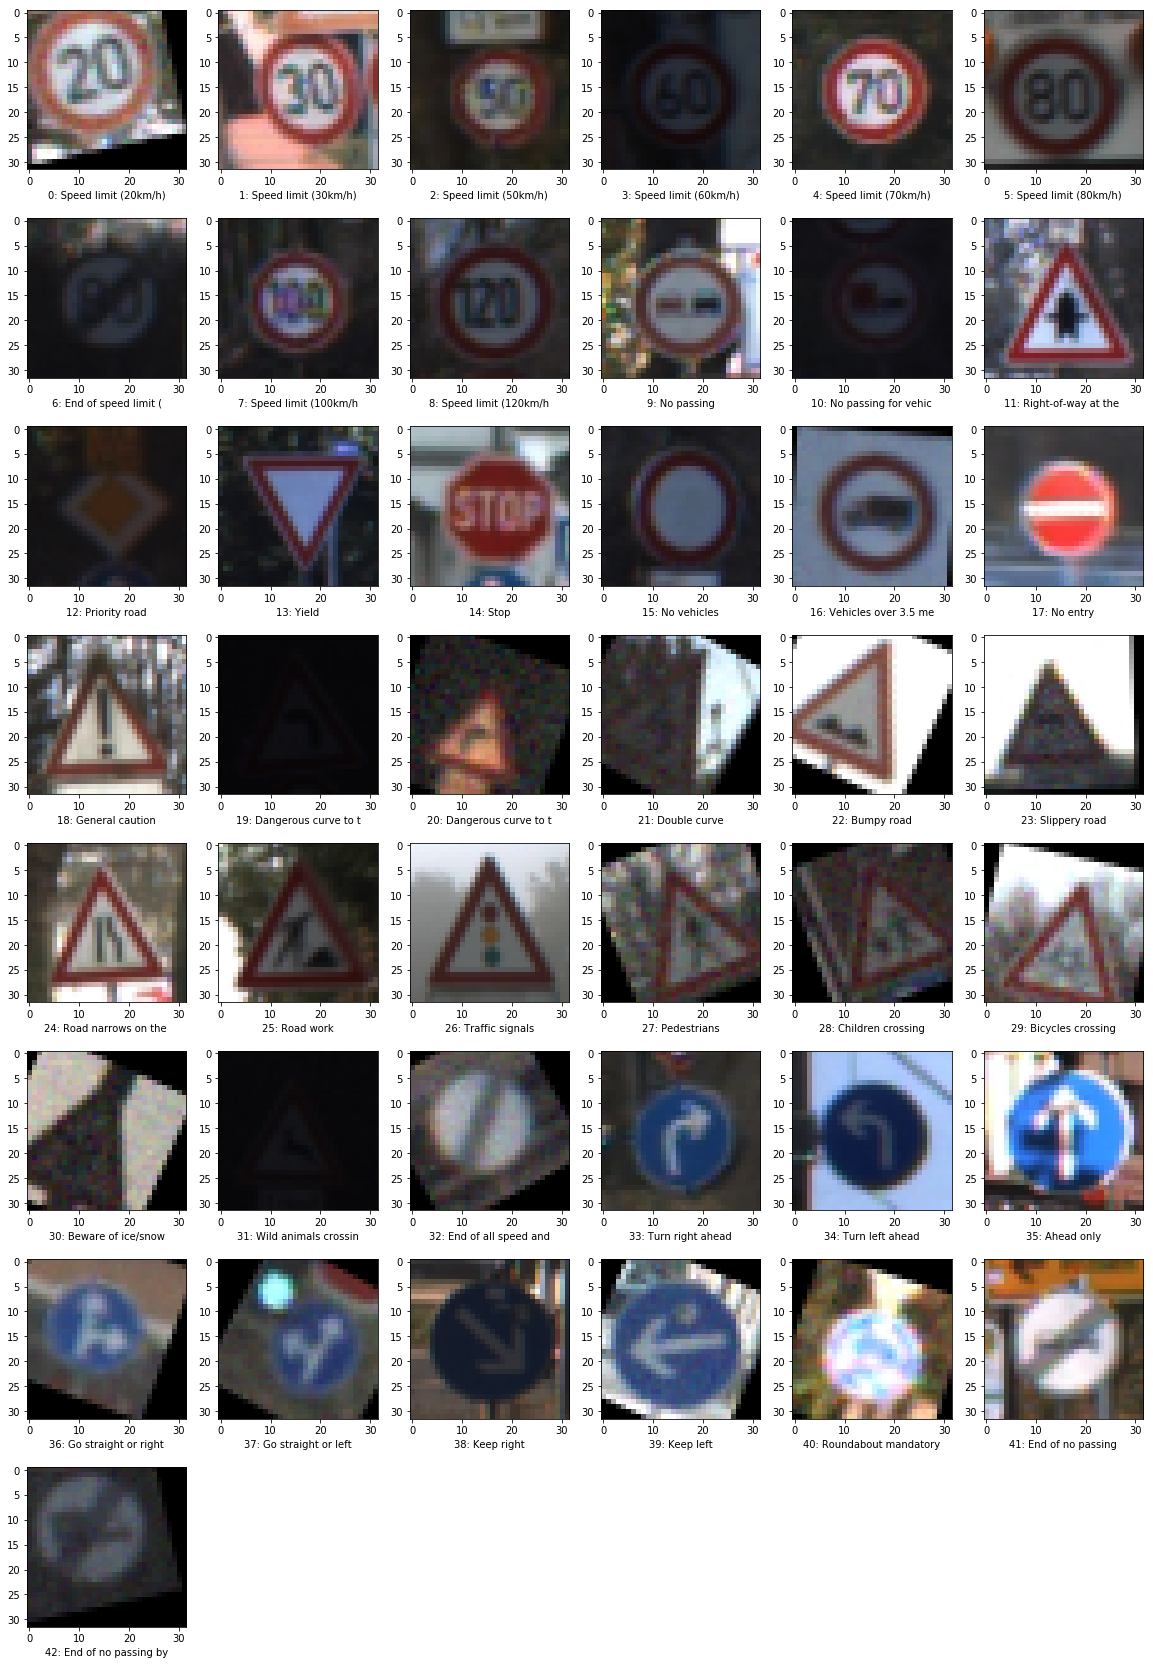

In [6]:
# Apply data augmentation and balance dataset
X_train, y_train = balance_data(X_train_raw, y_train_raw, classes_dics_raw, data_label = 'train', desired_samples = 1000)

# Classes dictionaries for new data set
classes_dics = summary_data_sets(y_train, y_valid_raw, y_test_raw, 'traffic-signs-data/signnames.csv')

# Get the total of samples for each class for validation, training and test data sets
means_training = [d['train'] for d in classes_dics if 'train' in d]

# Plot dataset samples distribution
plot_dataset(means_training, means_validation, means_test, n_classes, save_name = 'writeup_files/dataset_description_balanced_data.png')

# Show random samples for each class
show_dataset(X_train, classes_dics, data_label = "train", save_name = 'writeup_files/dataset_random_visualization_balanced.png')


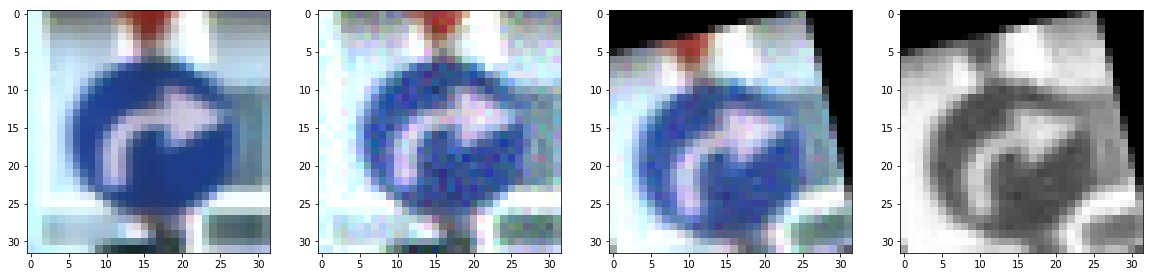

In [7]:
# Get a random sample to apply modifications
idx = np.random.randint(len(X_valid_raw))
X_valid_image = X_valid_raw[idx]
get_img_transformations(X_valid_image)


----

## Step 2: Designing, Training and Testing a Model Architecture

Next the designing and implementation of a deep learning model that learns to recognize traffic signs. Model was trained and tested with the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The Network is inspired in the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) and the lecture [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

There are various aspects were considered in this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Model Architecture
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.  
**Activation.** Your choice of activation function.  
**Pooling.** The output shape should be 14x14x6.  

**Layer 2: Convolutional.** The output shape should be 10x10x16.  
**Activation.** Your choice of activation function.  
**Pooling.** The output shape should be 5x5x16.  
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  
The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.  
**Activation.** Your choice of activation function.  

**Layer 4: Fully Connected.** This should have 84 outputs.  
**Activation.** Your choice of activation function.  

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.  

### Output
Return the result of the 2nd fully connected layer.

In [8]:
# Load and import dependencies for model
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import glob


In [9]:
# Hyper parameters
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.01
NUM_CHANNELS = 1
DATA_SRC_SIZE = (32, 32)

# Dataset adjusments
if NUM_CHANNELS == 1: # Convert dataset to gray scale
    X_train = np.asarray([norm_and_gray(img) for img in X_train_raw])
    X_valid = np.asarray([norm_and_gray(img) for img in X_valid_raw])
    X_test = np.asarray([norm_and_gray(img) for img in X_test_raw])
else:
    X_train = X_train_raw
    X_valid = X_valid_raw
    X_test = X_test_raw
    
y_valid = y_valid_raw
y_train = y_train_raw
y_test  = y_test_raw


In [10]:
def BetaNet(x):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases 
    # for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, NUM_CHANNELS, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1) # Activation.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2) # Activation.
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1) # Activation.
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2) # Activation.

    # Layer 5: Fully Connected. Input = 84. Output = n_classes = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

tf.reset_default_graph()
# `x` and 'y' for a batch of input images.
x = tf.placeholder(tf.float32, (None, DATA_SRC_SIZE[0], DATA_SRC_SIZE[1], NUM_CHANNELS))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Evaluate how well the loss and accuracy of the model for a given dataset.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


logits, conv1, conv2 = BetaNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Model Training
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.
You do not need to modify this section.

In [11]:
best_epoch = 0
best_val_acc = 0
history = []

with tf.Session() as sess:
    
    
    sess.run(tf.global_variables_initializer())

    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
#         X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {}: Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
        
    saver.save(sess, './model_results/betanet')
    print("Model saved")
    

Training...

EPOCH 1: Validation Accuracy = 0.824
EPOCH 2: Validation Accuracy = 0.885
EPOCH 3: Validation Accuracy = 0.900
EPOCH 4: Validation Accuracy = 0.894
EPOCH 5: Validation Accuracy = 0.895
Model saved


### Training Visualization

---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, more data was randomly downloaded from the web and used in the model to predict the traffic sign type.


### Loading New Data sets

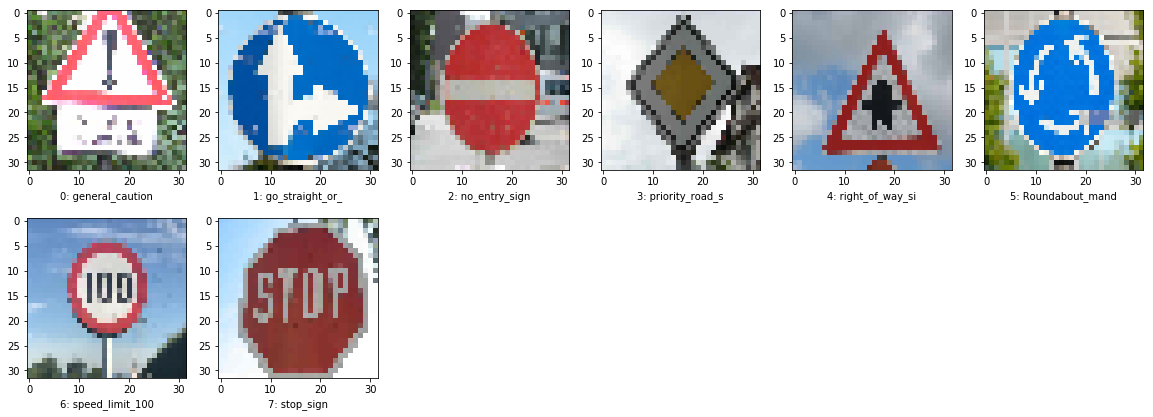

In [23]:
import cv2

path = "traffic-signs-data/other_signs"
extensions = ["jpg","gif","png","tga"]

# Load images in 'path'
image_path_list = [item for i in [glob.glob(path+'/*.%s' % ext) for ext in extensions] for item in i]
image_list = np.asarray([cv2.cvtColor(cv2.resize(cv2.imread(img_path), image_shape[:2]), cv2.COLOR_BGR2RGB) \
              for idx, img_path in enumerate(image_path_list)])

# Visualize new dataset
plt.figure(figsize=(20,30)); columns = 6
for idx in range(0, len(image_list) if len(image_list) <= 12 else 12):
    ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
    plt.imshow(image_list[idx])
    ax.set_xlabel(str(idx)+": "+image_path_list[idx].split("/")[-1].split(".")[0][0:15])
plt.savefig('writeup_files/new_data_set.png')
plt.show()


### Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./model_results/betanet
Test Accuracy = 0.881


### Visualizing Layers

image_input: the test image being fed into the network to produce the feature maps
tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
Note: that to get access to tf_activation, the session should be interactive which can be achieved with the following commands.
sess = tf.InteractiveSession()
sess.as_default()

activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and    max values of the output
plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry


In [20]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

INFO:tensorflow:Restoring parameters from ./model_results/betanet
Test Accuracy = 0.881


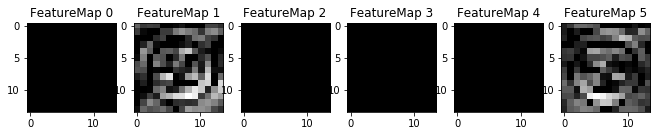

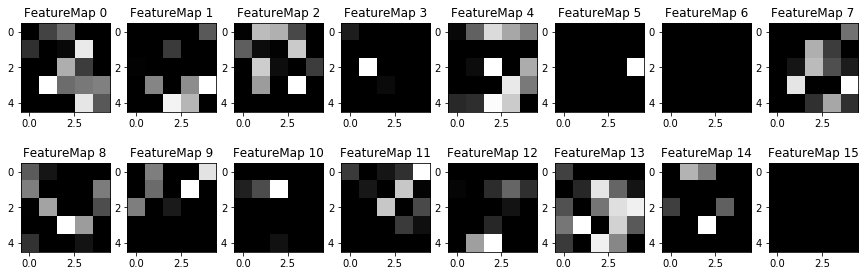

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    outputFeatureMap([X_train[0]], conv1, plt_num=1)
    outputFeatureMap([X_train[0]], conv2, plt_num=2)
    